In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [183]:
from project.ranker.ranker import RankingPredictor
from project.ranker.ranker import RandomRankingPredictor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from project.feature_selection.feature_selector import FeatureSelection

In [185]:
from project.meta_feature.extractor import MFRCollection

In [191]:
rr = RandomRankingPredictor()
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])

In [186]:
%%time
df_mf, df_rank, df_scores, df_fold_scores = rp.named_steps['estimator'].get_data()

CPU times: user 54.6 s, sys: 3.08 s, total: 57.7 s
Wall time: 57.7 s


In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, y_scores_train, y_scores_test = train_test_split(df_mf.values,
                                                                                   df_rank.values,
                                                                                   df_scores.values,
                                                                                   test_size=0)

In [189]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 39), (0, 39), (60, 13), (0, 13))

In [190]:
from project.utils.metrics import evaluate_metric

In [192]:
def cv_random(rr, X, y, y_scores, kfolds):
    results = []
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_val, y_val = X[val_idx], y[val_idx]
        X_trn, y_trn = X[trn_idx], y[trn_idx]
        y_scores_trn = y_scores[trn_idx]
        y_scores_val = y_scores[val_idx]
        
        rr.fit(X_trn, y_trn)
        y_pred_trn = rr.predict(y_trn)
        y_pred_val = rr.predict(y_val)
        
        trn_spearman = evaluate_metric("spearman", y_trn, y_pred_trn)
        trn_acc_loss = evaluate_metric("mean_acc_loss", y_scores_trn, y_pred_trn)
        val_spearman = evaluate_metric("spearman", y_val, y_pred_val)
        val_acc_loss = evaluate_metric("mean_acc_loss", y_scores_val, y_pred_val)
        print(f'Fold {idx + 1} | '
              f'Train Spearman: {trn_spearman:.4f} | '
              f'Valid Spearman: {val_spearman:.4f} | '
              f'Train ACC Loss: {trn_acc_loss:.4f} | '
              f'Valid ACC Loss: {val_acc_loss:.4f}')
        
        results.append((trn_spearman, val_spearman, trn_acc_loss, val_acc_loss))
          
    results = np.array(results)
    print()
    print(f'Train Spearman: {results[:,0].mean():.4f} +/-{results[:,0].std()*2:.4f} | '
          f'Valid Spearman: {results[:,1].mean():.4f} +/-{results[:,1].std()*2:.4f}\n'
          f'Train ACC Loss: {results[:,2].mean():.4f} +/-{results[:,2].std()*2:.4f} | '
          f'Valid ACC Loss: {results[:,3].mean():.4f} +/-{results[:,3].std()*2:.4f}')
    print()
    return results

In [178]:
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
results = cv_random(rr, X_train, y_train, y_scores_train, kfolds)

Fold 1 | Train Spearman: 0.0282 | Valid Spearman: -0.1706 | Train ACC Loss: 0.0895 | Valid ACC Loss: 0.1098
Fold 2 | Train Spearman: 0.0697 | Valid Spearman: 0.0675 | Train ACC Loss: 0.0757 | Valid ACC Loss: 0.0309
Fold 3 | Train Spearman: 0.0340 | Valid Spearman: 0.2421 | Train ACC Loss: 0.0636 | Valid ACC Loss: 0.0277
Fold 4 | Train Spearman: 0.0212 | Valid Spearman: 0.0833 | Train ACC Loss: 0.0827 | Valid ACC Loss: 0.0118
Fold 5 | Train Spearman: -0.0498 | Valid Spearman: -0.0317 | Train ACC Loss: 0.0791 | Valid ACC Loss: 0.0587
Fold 6 | Train Spearman: -0.0181 | Valid Spearman: -0.0833 | Train ACC Loss: 0.0733 | Valid ACC Loss: 0.1250
Fold 7 | Train Spearman: -0.0423 | Valid Spearman: -0.2222 | Train ACC Loss: 0.0849 | Valid ACC Loss: 0.1366
Fold 8 | Train Spearman: -0.0049 | Valid Spearman: -0.1032 | Train ACC Loss: 0.0736 | Valid ACC Loss: 0.0873
Fold 9 | Train Spearman: 0.0238 | Valid Spearman: 0.3413 | Train ACC Loss: 0.0708 | Valid ACC Loss: 0.0895
Fold 10 | Train Spearman: -0

In [193]:
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
results = cv_random(rr, X_train, y_train, y_scores_train, kfolds)

Fold 1 | Train Spearman: -0.0881 | Valid Spearman: -0.0183 | Train ACC Loss: 0.1356 | Valid ACC Loss: 0.0862
Fold 2 | Train Spearman: 0.0273 | Valid Spearman: -0.0082 | Train ACC Loss: 0.1174 | Valid ACC Loss: 0.2514
Fold 3 | Train Spearman: -0.0051 | Valid Spearman: 0.1218 | Train ACC Loss: 0.1243 | Valid ACC Loss: 0.1422
Fold 4 | Train Spearman: -0.0061 | Valid Spearman: 0.0156 | Train ACC Loss: 0.1334 | Valid ACC Loss: 0.0962
Fold 5 | Train Spearman: -0.0329 | Valid Spearman: -0.0696 | Train ACC Loss: 0.1484 | Valid ACC Loss: 0.0589
Fold 6 | Train Spearman: 0.0790 | Valid Spearman: 0.0137 | Train ACC Loss: 0.0996 | Valid ACC Loss: 0.0698
Fold 7 | Train Spearman: 0.0316 | Valid Spearman: 0.3516 | Train ACC Loss: 0.1137 | Valid ACC Loss: 0.0550
Fold 8 | Train Spearman: 0.0503 | Valid Spearman: 0.0614 | Train ACC Loss: 0.1126 | Valid ACC Loss: 0.1725
Fold 9 | Train Spearman: 0.1028 | Valid Spearman: -0.0971 | Train ACC Loss: 0.0955 | Valid ACC Loss: 0.1943
Fold 10 | Train Spearman: -0.

In [ ]:
Train Spearman: -0.0080 +/-0.0886 | Valid Spearman: 0.0044 +/-0.2451
Train ACC Loss: 0.1396 +/-0.0380 | Valid ACC Loss: 0.1385 +/-0.1440

In [ ]:
Train Spearman: 0.2635 +/-0.0538 | Valid Spearman: 0.1410 +/-0.2459
Train ACC Loss: 0.1033 +/-0.0211 | Valid ACC Loss: 0.1208 +/-0.1218

In [172]:
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
results = cv_random(rr, X_train, y_train, y_scores_train, kfolds)

Fold 1 | Train Spearman: 0.0855 | Valid Spearman: 0.0476 | Train ACC Loss: 0.0719 | Valid ACC Loss: 0.0541
Fold 2 | Train Spearman: 0.0913 | Valid Spearman: -0.0238 | Train ACC Loss: 0.0832 | Valid ACC Loss: 0.1207
Fold 3 | Train Spearman: 0.0644 | Valid Spearman: 0.1468 | Train ACC Loss: 0.0834 | Valid ACC Loss: 0.0424
Fold 4 | Train Spearman: -0.0238 | Valid Spearman: -0.0595 | Train ACC Loss: 0.0742 | Valid ACC Loss: 0.0341
Fold 5 | Train Spearman: -0.0207 | Valid Spearman: 0.1349 | Train ACC Loss: 0.0682 | Valid ACC Loss: 0.0829
Fold 6 | Train Spearman: -0.0304 | Valid Spearman: 0.3254 | Train ACC Loss: 0.0696 | Valid ACC Loss: 0.0581
Fold 7 | Train Spearman: 0.0040 | Valid Spearman: 0.0992 | Train ACC Loss: 0.0834 | Valid ACC Loss: 0.0387
Fold 8 | Train Spearman: -0.0207 | Valid Spearman: 0.1786 | Train ACC Loss: 0.0839 | Valid ACC Loss: 0.0844
Fold 9 | Train Spearman: 0.0150 | Valid Spearman: 0.0437 | Train ACC Loss: 0.0680 | Valid ACC Loss: 0.1016
Fold 10 | Train Spearman: 0.018

In [25]:
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
results = cv_random(rr, X_train, y_train, y_scores_train, kfolds)

Fold 1 | Train Spearman: 0.0335 | Valid Spearman: 0.0595 | Train ACC Loss: 0.1331 | Valid ACC Loss: 0.1389
Fold 2 | Train Spearman: -0.0013 | Valid Spearman: -0.0952 | Train ACC Loss: 0.1407 | Valid ACC Loss: 0.2029
Fold 3 | Train Spearman: -0.0847 | Valid Spearman: 0.0357 | Train ACC Loss: 0.1560 | Valid ACC Loss: 0.0649
Fold 4 | Train Spearman: -0.0304 | Valid Spearman: -0.0675 | Train ACC Loss: 0.1320 | Valid ACC Loss: 0.2734
Fold 5 | Train Spearman: 0.0057 | Valid Spearman: 0.4286 | Train ACC Loss: 0.1340 | Valid ACC Loss: 0.1071
Fold 6 | Train Spearman: 0.0026 | Valid Spearman: 0.1032 | Train ACC Loss: 0.1441 | Valid ACC Loss: 0.1769
Fold 7 | Train Spearman: 0.0106 | Valid Spearman: -0.1310 | Train ACC Loss: 0.1474 | Valid ACC Loss: 0.1369
Fold 8 | Train Spearman: 0.0340 | Valid Spearman: -0.1746 | Train ACC Loss: 0.1397 | Valid ACC Loss: 0.1043
Fold 9 | Train Spearman: -0.0071 | Valid Spearman: 0.1349 | Train ACC Loss: 0.1229 | Valid ACC Loss: 0.1283
Fold 10 | Train Spearman: -0.

## LGBM

In [194]:
def wide2long(X, y):
    n_samples, n_classes = y.shape
    X_cont = np.repeat(X, n_classes, axis=0)
    X_cats = np.array(list(range(n_classes)) * n_samples)[:, None]
    return np.concatenate([X_cont, X_cats], axis=1), y.reshape(-1)

In [195]:
def cv_lgbm(lightgbm, X, y, y_scores, kfolds, params, num_rounds=1000, 
            early_stopping_rounds=30, verbose_eval=False):
    results = []
    models = []
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_val, y_val = X[val_idx], y[val_idx]
        X_trn, y_trn = X[trn_idx], y[trn_idx]
        y_scores_trn = y_scores[trn_idx]
        y_scores_val = y_scores[val_idx]
        
        X_trn_long, y_trn_long = wide2long(X_trn, y_trn)
        X_val_long, y_val_long = wide2long(X_val, y_val)
        
        dtrn = lightgbm.Dataset(X_trn_long, y_trn_long, group=[y_trn.shape[1]] * y_trn.shape[0])
        dval = lightgbm.Dataset(X_val_long, y_val_long, group=[y_val.shape[1]] * y_val.shape[0])
        
        bst = lightgbm.train(params, dtrn, num_rounds, [dtrn, dval],
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose_eval)
        
        y_pred_trn = [bst.predict(wide2long(x[None,:], y[None,:])[0], 
                                  num_iterations=bst.best_iteration) for x, y in zip(X_trn, y_trn)]
        y_pred_val = [bst.predict(wide2long(x[None,:], y[None,:])[0], 
                                  num_iterations=bst.best_iteration) for x, y in zip(X_val, y_val)]
    
        y_pred_trn = np.argsort(y_pred_trn)
        y_pred_val = np.argsort(y_pred_val)
        
        trn_spearman = evaluate_metric("spearman", y_trn, y_pred_trn)
        trn_acc_loss = evaluate_metric("mean_acc_loss", y_scores_trn, y_pred_trn)
        val_spearman = evaluate_metric("spearman", y_val, y_pred_val)
        val_acc_loss = evaluate_metric("mean_acc_loss", y_scores_val, y_pred_val)
        print(f'Fold {idx + 1} | '
              f'No. estimators: {bst.best_iteration} | '
              f'Train Spearman: {trn_spearman:.4f} | '
              f'Valid Spearman: {val_spearman:.4f} | '
              f'Train ACC Loss: {trn_acc_loss:.4f} | '
              f'Valid ACC Loss: {val_acc_loss:.4f}')
        print()
        results.append((trn_spearman, val_spearman, trn_acc_loss, val_acc_loss))
        models.append(bst)
          
    results = np.array(results)
    print()
    print(f'Train Spearman: {results[:,0].mean():.4f} +/-{results[:,0].std()*2:.4f} | '
          f'Valid Spearman: {results[:,1].mean():.4f} +/-{results[:,1].std()*2:.4f}\n'
          f'Train ACC Loss: {results[:,2].mean():.4f} +/-{results[:,2].std()*2:.4f} | '
          f'Valid ACC Loss: {results[:,3].mean():.4f} +/-{results[:,3].std()*2:.4f}')
    print()
    return results, models

In [155]:
X_long, y_long = wide2long(X_train, y_train)

In [196]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100, early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@13: 0.769042	valid_1's ndcg@13: 0.521576
[20]	training's ndcg@13: 0.774251	valid_1's ndcg@13: 0.507747
[30]	training's ndcg@13: 0.793293	valid_1's ndcg@13: 0.499604
[40]	training's ndcg@13: 0.792121	valid_1's ndcg@13: 0.497481
[50]	training's ndcg@13: 0.811407	valid_1's ndcg@13: 0.511755
Early stopping, best iteration is:
[8]	training's ndcg@13: 0.754273	valid_1's ndcg@13: 0.582947
Fold 1 | No. estimators: 8 | Train Spearman: 0.2515 | Valid Spearman: 0.2152 | Train ACC Loss: 0.1049 | Valid ACC Loss: 0.0301

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@13: 0.787419	valid_1's ndcg@13: 0.508377
[20]	training's ndcg@13: 0.79903	valid_1's ndcg@13: 0.499196
[30]	training's ndcg@13: 0.801507	valid_1's ndcg@13: 0.502367
[40]	training's ndcg@13: 0.814417	valid_1's ndcg@13: 0.49757
[50]	training's ndcg@13: 0.817481	valid_1's ndcg@13: 0.498034
[60]	training's ndcg@13: 0.81739	v

In [98]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
          'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100, early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.927301	valid_1's ndcg@8: 0.577425
[20]	training's ndcg@8: 0.935802	valid_1's ndcg@8: 0.653652
[30]	training's ndcg@8: 0.93761	valid_1's ndcg@8: 0.606961
[40]	training's ndcg@8: 0.9352	valid_1's ndcg@8: 0.534368
[50]	training's ndcg@8: 0.936503	valid_1's ndcg@8: 0.553274
[60]	training's ndcg@8: 0.939714	valid_1's ndcg@8: 0.570982
[70]	training's ndcg@8: 0.939184	valid_1's ndcg@8: 0.611475
Early stopping, best iteration is:
[20]	training's ndcg@8: 0.935802	valid_1's ndcg@8: 0.653652
Fold 1 | No. estimators: 20 | Train Spearman: 0.1543 | Valid Spearman: 0.0992 | Train ACC Loss: 0.1205 | Valid ACC Loss: 0.1681

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.910413	valid_1's ndcg@8: 0.671779
[20]	training's ndcg@8: 0.911979	valid_1's ndcg@8: 0.681711
[30]	training's ndcg@8: 0.914993	valid_1's ndcg@8: 0.675768
[40]	training's ndcg@8: 0.923319	valid_1's ndcg@8: 0.68

In [94]:
X_long, y_long = wide2long(X_train, y_train)
X_long.shape

(480, 40)

In [85]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
          'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100, early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.927301	valid_1's ndcg@8: 0.577425
[20]	training's ndcg@8: 0.935802	valid_1's ndcg@8: 0.653652
[30]	training's ndcg@8: 0.93761	valid_1's ndcg@8: 0.606961
[40]	training's ndcg@8: 0.9352	valid_1's ndcg@8: 0.534368
[50]	training's ndcg@8: 0.936503	valid_1's ndcg@8: 0.553274
[60]	training's ndcg@8: 0.939714	valid_1's ndcg@8: 0.570982
[70]	training's ndcg@8: 0.939184	valid_1's ndcg@8: 0.611475
Early stopping, best iteration is:
[20]	training's ndcg@8: 0.935802	valid_1's ndcg@8: 0.653652
Fold 1 | No. estimators: 20 | Train Spearman: 0.1543 | Valid Spearman: 0.0992 | Train ACC Loss: 0.1205 | Valid ACC Loss: 0.1681

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.910413	valid_1's ndcg@8: 0.671779
[20]	training's ndcg@8: 0.911979	valid_1's ndcg@8: 0.681711
[30]	training's ndcg@8: 0.914993	valid_1's ndcg@8: 0.675768
[40]	training's ndcg@8: 0.923319	valid_1's ndcg@8: 0.68

In [86]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100, early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.85482	valid_1's ndcg@8: 0.659777
[20]	training's ndcg@8: 0.8939	valid_1's ndcg@8: 0.66918
[30]	training's ndcg@8: 0.898238	valid_1's ndcg@8: 0.650088
[40]	training's ndcg@8: 0.897641	valid_1's ndcg@8: 0.661768
[50]	training's ndcg@8: 0.897345	valid_1's ndcg@8: 0.658733
Early stopping, best iteration is:
[2]	training's ndcg@8: 0.824817	valid_1's ndcg@8: 0.70617
Fold 1 | No. estimators: 2 | Train Spearman: 0.1539 | Valid Spearman: 0.0476 | Train ACC Loss: 0.1324 | Valid ACC Loss: 0.2034

Training until validation scores don't improve for 50 rounds.
[10]	training's ndcg@8: 0.879183	valid_1's ndcg@8: 0.684186
[20]	training's ndcg@8: 0.901749	valid_1's ndcg@8: 0.730055
[30]	training's ndcg@8: 0.899597	valid_1's ndcg@8: 0.721385
[40]	training's ndcg@8: 0.899198	valid_1's ndcg@8: 0.721385
[50]	training's ndcg@8: 0.90579	valid_1's ndcg@8: 0.708866
[60]	training's ndcg@8: 0.9018	valid_1's ndcg@8: 0.708866
Ea

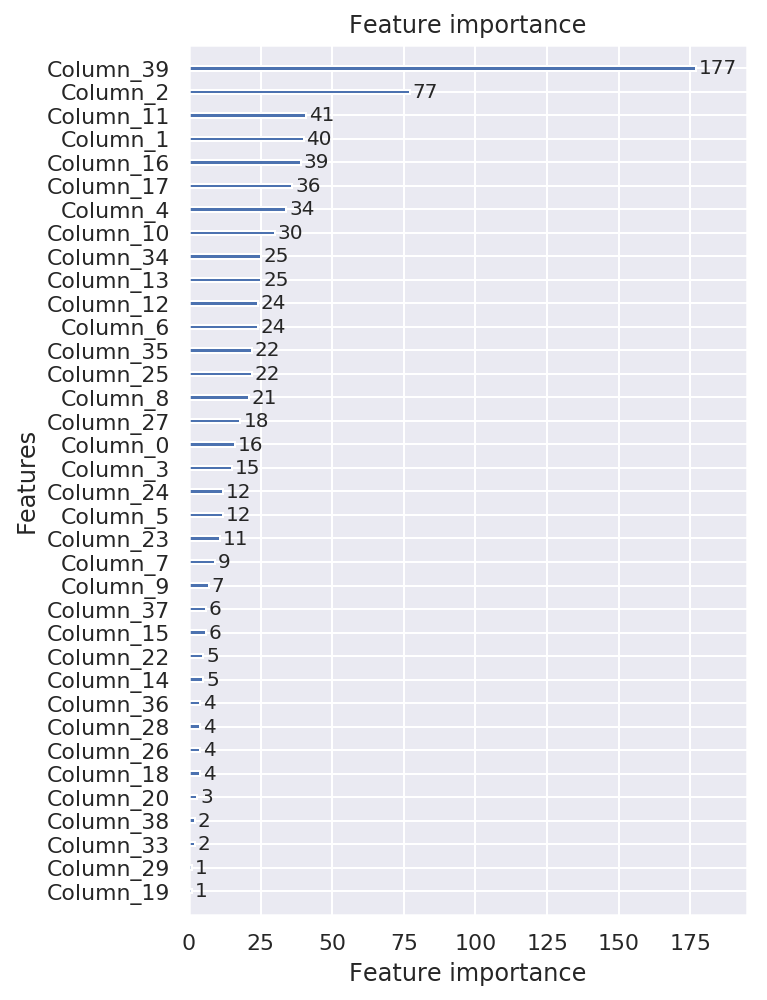

In [104]:
lightgbm.plot_importance(models[5], figsize=(5,8))

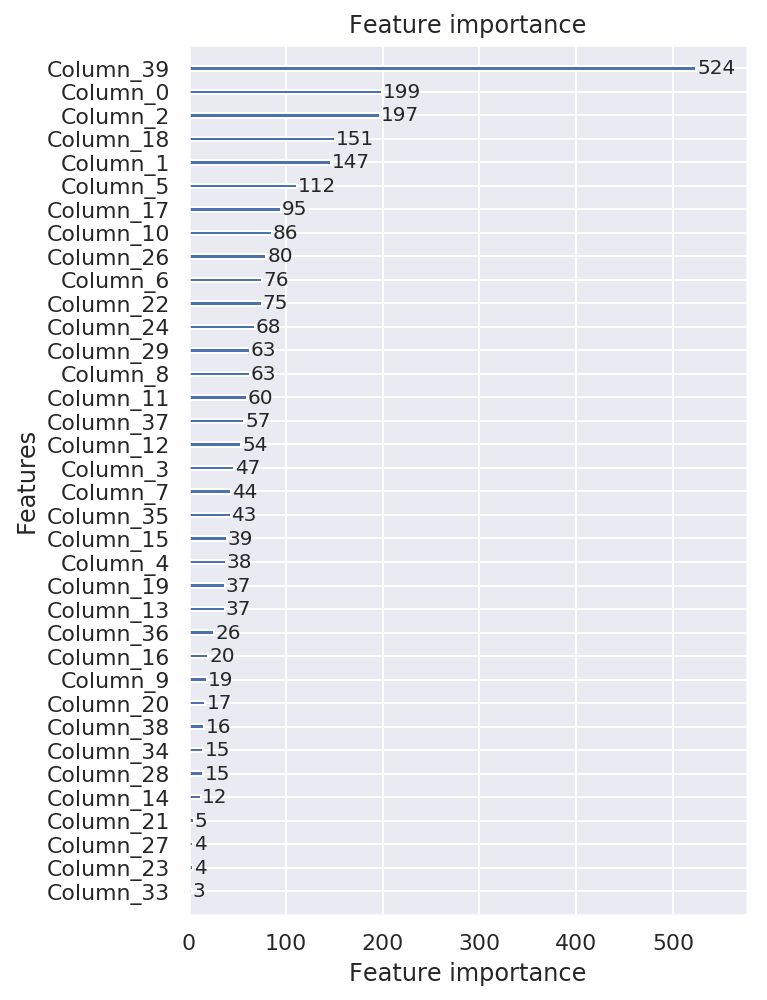

In [103]:
lightgbm.plot_importance(models[3], figsize=(5,8))

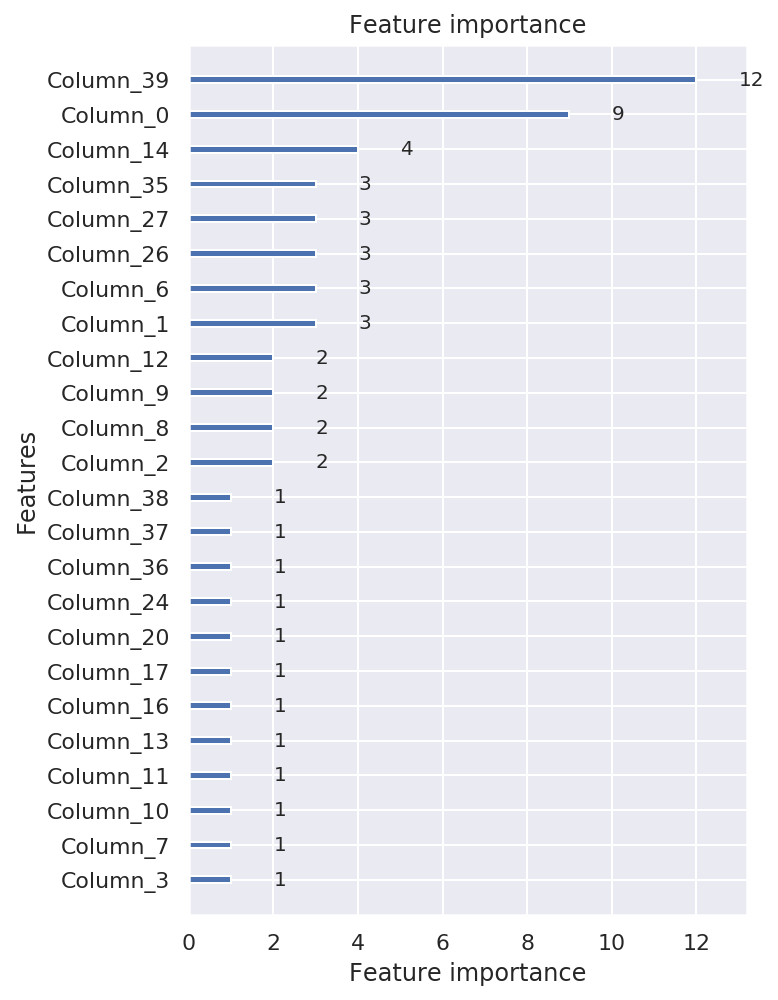

In [91]:
lightgbm.plot_importance(models[0], figsize=(5,8))

In [71]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=50, early_stopping_rounds=None, verbose_eval=10)

[10]	valid_0's ndcg@8: 0.720111
[20]	valid_0's ndcg@8: 0.62472
[30]	valid_0's ndcg@8: 0.595268
[40]	valid_0's ndcg@8: 0.605687
[50]	valid_0's ndcg@8: 0.603918
Fold 1 | No. estimators: 0 | Train Spearman: 0.2632 | Valid Spearman: 0.2738 | Train ACC Loss: 0.1051 | Valid ACC Loss: 0.2087
[10]	valid_0's ndcg@8: 0.583101
[20]	valid_0's ndcg@8: 0.585302
[30]	valid_0's ndcg@8: 0.694008
[40]	valid_0's ndcg@8: 0.698356
[50]	valid_0's ndcg@8: 0.64688
Fold 2 | No. estimators: 0 | Train Spearman: 0.3549 | Valid Spearman: -0.1071 | Train ACC Loss: 0.1163 | Valid ACC Loss: 0.0784
[10]	valid_0's ndcg@8: 0.658394
[20]	valid_0's ndcg@8: 0.640945
[30]	valid_0's ndcg@8: 0.628807
[40]	valid_0's ndcg@8: 0.585883
[50]	valid_0's ndcg@8: 0.565551
Fold 3 | No. estimators: 0 | Train Spearman: 0.3056 | Valid Spearman: -0.0635 | Train ACC Loss: 0.1115 | Valid ACC Loss: 0.1193
[10]	valid_0's ndcg@8: 0.642553
[20]	valid_0's ndcg@8: 0.584364
[30]	valid_0's ndcg@8: 0.579626
[40]	valid_0's ndcg@8: 0.570241
[50]	valid_

In [70]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=50, early_stopping_rounds=None, verbose_eval=False)

Fold 1 | No. estimators: 0 | Train Spearman: 0.2632 | Valid Spearman: 0.2738 | Train ACC Loss: 0.1051 | Valid ACC Loss: 0.2087
Fold 2 | No. estimators: 0 | Train Spearman: 0.3549 | Valid Spearman: -0.1071 | Train ACC Loss: 0.1163 | Valid ACC Loss: 0.0784
Fold 3 | No. estimators: 0 | Train Spearman: 0.3056 | Valid Spearman: -0.0635 | Train ACC Loss: 0.1115 | Valid ACC Loss: 0.1193
Fold 4 | No. estimators: 0 | Train Spearman: 0.2800 | Valid Spearman: -0.1429 | Train ACC Loss: 0.1198 | Valid ACC Loss: 0.0872
Fold 5 | No. estimators: 0 | Train Spearman: 0.3519 | Valid Spearman: 0.0040 | Train ACC Loss: 0.1106 | Valid ACC Loss: 0.1889
Fold 6 | No. estimators: 0 | Train Spearman: 0.2884 | Valid Spearman: 0.3532 | Train ACC Loss: 0.1043 | Valid ACC Loss: 0.1326
Fold 7 | No. estimators: 0 | Train Spearman: 0.2707 | Valid Spearman: -0.1389 | Train ACC Loss: 0.1147 | Valid ACC Loss: 0.1650
Fold 8 | No. estimators: 0 | Train Spearman: 0.3047 | Valid Spearman: 0.0873 | Train ACC Loss: 0.1111 | Val

In [69]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 1,
          'min_sum_hessian_in_leaf': 0}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=50, early_stopping_rounds=None, verbose_eval=False)

Fold 1 | No. estimators: 0 | Train Spearman: 0.2747 | Valid Spearman: -0.0754 | Train ACC Loss: 0.1100 | Valid ACC Loss: 0.2281
Fold 2 | No. estimators: 0 | Train Spearman: 0.2941 | Valid Spearman: -0.0873 | Train ACC Loss: 0.1233 | Valid ACC Loss: 0.0611
Fold 3 | No. estimators: 0 | Train Spearman: 0.2813 | Valid Spearman: -0.1429 | Train ACC Loss: 0.1187 | Valid ACC Loss: 0.1356
Fold 4 | No. estimators: 0 | Train Spearman: 0.2341 | Valid Spearman: -0.1310 | Train ACC Loss: 0.1280 | Valid ACC Loss: 0.0749
Fold 5 | No. estimators: 0 | Train Spearman: 0.2941 | Valid Spearman: 0.1508 | Train ACC Loss: 0.1059 | Valid ACC Loss: 0.2220
Fold 6 | No. estimators: 0 | Train Spearman: 0.2959 | Valid Spearman: 0.1786 | Train ACC Loss: 0.1208 | Valid ACC Loss: 0.1551
Fold 7 | No. estimators: 0 | Train Spearman: 0.2901 | Valid Spearman: 0.0595 | Train ACC Loss: 0.1218 | Valid ACC Loss: 0.1579
Fold 8 | No. estimators: 0 | Train Spearman: 0.3188 | Valid Spearman: 0.2024 | Train ACC Loss: 0.1066 | Val

In [64]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 5}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100, early_stopping_rounds=None)

Fold 1 | No. estimators: 0 | Train Spearman: 0.3126 | Valid Spearman: 0.0913 | Train ACC Loss: 0.1157 | Valid ACC Loss: 0.1944
Fold 2 | No. estimators: 0 | Train Spearman: 0.2319 | Valid Spearman: -0.1111 | Train ACC Loss: 0.1366 | Valid ACC Loss: 0.0818
Fold 3 | No. estimators: 0 | Train Spearman: 0.2813 | Valid Spearman: 0.0913 | Train ACC Loss: 0.1295 | Valid ACC Loss: 0.1173
Fold 4 | No. estimators: 0 | Train Spearman: 0.2853 | Valid Spearman: -0.3016 | Train ACC Loss: 0.1369 | Valid ACC Loss: 0.0644
Fold 5 | No. estimators: 0 | Train Spearman: 0.2385 | Valid Spearman: 0.0873 | Train ACC Loss: 0.1078 | Valid ACC Loss: 0.1912
Fold 6 | No. estimators: 0 | Train Spearman: 0.2597 | Valid Spearman: 0.1270 | Train ACC Loss: 0.1151 | Valid ACC Loss: 0.1558
Fold 7 | No. estimators: 0 | Train Spearman: 0.2848 | Valid Spearman: -0.0317 | Train ACC Loss: 0.1171 | Valid ACC Loss: 0.1577
Fold 8 | No. estimators: 0 | Train Spearman: 0.2751 | Valid Spearman: -0.3095 | Train ACC Loss: 0.1164 | Val

In [ ]:
%%time
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 5}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=100)

In [52]:
import lightgbm
from sklearn.model_selection import KFold
kfolds = KFold(10, shuffle=True, random_state=42)
params = {'objective': 'lambdarank', 'metric': 'ndcg'}
results = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, params)

[1]	valid_0's ndcg@1: 0.133333	valid_0's ndcg@2: 0.159816	valid_0's ndcg@3: 0.39202	valid_0's ndcg@4: 0.446629	valid_0's ndcg@5: 0.506428
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's ndcg@1: 0.069281	valid_0's ndcg@2: 0.0797009	valid_0's ndcg@3: 0.198321	valid_0's ndcg@4: 0.359477	valid_0's ndcg@5: 0.431284
[3]	valid_0's ndcg@1: 0.220915	valid_0's ndcg@2: 0.2616	valid_0's ndcg@3: 0.434599	valid_0's ndcg@4: 0.489223	valid_0's ndcg@5: 0.543702
[4]	valid_0's ndcg@1: 0.299346	valid_0's ndcg@2: 0.470636	valid_0's ndcg@3: 0.596581	valid_0's ndcg@4: 0.662137	valid_0's ndcg@5: 0.663208
[5]	valid_0's ndcg@1: 0.11634	valid_0's ndcg@2: 0.281181	valid_0's ndcg@3: 0.392037	valid_0's ndcg@4: 0.516918	valid_0's ndcg@5: 0.558278
[6]	valid_0's ndcg@1: 0.150327	valid_0's ndcg@2: 0.263114	valid_0's ndcg@3: 0.386886	valid_0's ndcg@4: 0.462078	valid_0's ndcg@5: 0.534681
[7]	valid_0's ndcg@1: 0.210458	valid_0's ndcg@2: 0.352796	valid_0's ndcg@3: 0.416131	valid_0's ndcg@4: 0.52

In [81]:
pd.DataFrame(y_trn_pred.reshape(*y_train.shape)).head()

,0,1,2,3,4,5,6,7
0,-0.016975,0.178613,0.515510,0.257870,-0.648984,-0.755250,-0.680263,-0.358872
1,-0.287769,-0.265789,-0.271825,-0.615658,-1.049278,-0.220794,0.603262,0.393828
2,-0.808988,-0.971056,-0.740450,-0.896691,-0.804690,-0.169520,0.085088,0.239131
3,-0.569542,-0.031412,-0.225745,0.506981,0.345174,0.838387,0.154664,0.238592
4,0.596260,0.208392,-0.052182,-0.461827,-0.954403,-0.535102,-0.396171,-0.162349


In [82]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7
0,2,3,8,6,4,5,1,7
1,3,5,1,7,2,4,8,6
2,3,5,1,2,4,6,7,8
3,1,3,4,7,6,8,2,5
4,8,3,7,1,5,2,6,4


In [83]:
pd.DataFrame(y_tst_pred.reshape(*y_test.shape)).head()

,0,1,2,3,4,5,6,7
0,-0.178293,0.340332,-0.253706,-0.309642,-1.076080,-0.450771,-0.164009,-0.154185
1,-0.715041,-0.314437,-0.339207,-0.262516,-0.855816,-0.325488,-0.160882,0.114249
2,-0.086199,-0.543968,-0.617068,-1.022921,-1.285527,-1.071132,-0.896273,-1.007780
3,-0.700709,-0.884632,-0.690102,-0.666368,-0.611320,-0.281327,-0.201452,0.075110
4,-0.613858,-0.316625,-0.629935,-0.534206,-0.985201,-0.339851,-0.057919,0.229094


In [84]:
pd.DataFrame(y_test).head()

,0,1,2,3,4,5,6,7
0,8,2,4,1,5,3,6,7
1,3,4,2,5,8,7,6,1
2,1,8,2,4,5,6,3,7
3,7,1,2,6,5,4,8,3
4,3,6,1,8,2,5,4,7
